In [7]:
import vectorbt as vb
from pykrx import stock
import pandas as pd
import time

# PBR+PER 시가총액별 콤보 전략

In [8]:
df1 = stock.get_market_cap("20100104")
df1 = df1[["종가", "시가총액"]]
df1.columns = ["시가", "시가총액"]
df1 = df1.sort_values('시가총액')
df1['group'] = pd.cut(df1.reset_index().index, bins=3, labels=['소형주', '중형주', '대형주'])

In [9]:
df1

,시가,시가총액,group
티커,,,
001385,5466000,60126000,소형주
020075,3750,75000000,소형주
009815,641000,110893000,소형주
033855,12850,145873200,소형주
017555,174500,177990000,소형주
...,...,...,...
015760,34250,21973694136000,대형주
105560,59400,22949290564200,대형주
005380,119000,26212901001000,대형주


In [10]:
df2 = stock.get_market_fundamental ("20100104")
df2 = df2[['PER', 'PBR']]

In [11]:
df3 = stock.get_market_ohlcv("20101230")
df3 = df3[['종가']]

In [12]:
df3

,종가
티커,
004560,11250
004565,12450
001460,161000
001465,74400
001040,78900
...,...
069260,19600
000540,6100
000547,6000


In [13]:
t0 = pd.merge(left=df1, right=df2, left_index=True, right_index=True)
df = pd.merge(left=df3, right=t0, left_index=True, right_index=True)

In [14]:
t0

,시가,시가총액,group,PER,PBR
티커,,,,,
001385,5466000,60126000,소형주,0.00,0.00
009815,641000,110893000,소형주,0.00,0.00
017555,174500,177990000,소형주,0.00,0.00
012405,7470,179280000,소형주,0.00,0.00
018415,170000,192780000,소형주,0.00,0.00
...,...,...,...,...,...
015760,34250,21973694136000,대형주,0.00,0.51
105560,59400,22949290564200,대형주,0.00,0.00
005380,119000,26212901001000,대형주,22.35,1.57


In [15]:
df = df.query('PBR != 0')
df['수익률'] = df['종가'] / df['시가']
cond = (df['PER'] >= 2.5) & (df['PER'] <= 10)
top30 = df[cond].sort_values('PBR').groupby('group').head(30)

In [16]:
import numpy as np

how = {
    '수익률' : np.mean
}
yoy = top30.groupby('group').agg(how)
yoy.columns = ['2010']
print(yoy)

           2010
group          
소형주    1.291967
중형주    1.115437
대형주    1.004330


# 함수

In [1]:
from datetime import datetime, timedelta
import numpy as np
import vectorbt as vb
from pykrx import stock
import pandas as pd
import time
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import warnings 
warnings.filterwarnings('ignore')

In [2]:
def date_range(start, end):
    start = datetime.strptime(start, '%Y%m%d')
    end = datetime.strptime(end, '%Y%m%d')
    dates = [start.strftime('%Y%m%d'), end.strftime('%Y%m%d')]
    dates = [stock.get_nearest_business_day_in_a_week(d) for d in dates]
    return dates

In [3]:
def low_per_pbr(year):
    dates = date_range(f"{year}0101", f"{year}1231")
    start = dates[0]
    end = dates[1]
    df1 = stock.get_market_cap(start)
    df1 = df1[["종가", "시가총액"]]
    df1.columns = ["시가", "시가총액"]
    df1 = df1.sort_values('시가총액')
    df1['group'] = pd.cut(df1.reset_index().index, bins=3, labels=['소형주', '중형주', '대형주'])
    
    df2 = stock.get_market_fundamental (start)
    df2 = df2[['PER', 'PBR']]
    
    df3 = stock.get_market_ohlcv(end)
    df3 = df3[['종가']]
    
    t0 = pd.merge(left=df1, right=df2, left_index=True, right_index=True)
    df = pd.merge(left=df3, right=t0, left_index=True, right_index=True)
    
    df = df.query('PBR != 0')
    df['수익률'] = df['종가'] / df['시가']
    cond = (df['PER'] >= 2.5) & (df['PER'] <= 15)
    top30 = df[cond].sort_values('PBR').groupby('group').head(30)
    
    how = {'수익률' : np.mean}
    yoy = top30.groupby('group').agg(how)
    yoy.columns = [f"{year}"]
    return yoy

In [4]:
dfs = [ ]
for date in range(2007, 2020):
    df = low_per_pbr(f"{date}")
    dfs.append(df)
    print(date, end=" ")
    time.sleep(1)
print("")
df = pd.concat(dfs, axis=1)
print(df)

2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 
           2007      2008      2009      2010      2011      2012      2013  \
group                                                                         
소형주    1.699672  0.549113  1.725836  1.271930  1.130756  1.994999  1.093434   
중형주    1.684479  0.486649  1.681727  1.063843  0.889110  1.194262  1.092358   
대형주    1.418151  0.646664  1.883903  1.137969  0.795723  1.109974  1.152098   

           2014      2015      2016      2017      2018      2019  
group                                                              
소형주    1.215777  1.629264  1.345687  1.025393  1.113899  1.173963  
중형주    1.431826  1.085603  1.165421  1.060468  0.947189  1.014922  
대형주    1.145731  1.145364  1.102614  1.120479  0.830155  0.948793  


In [23]:
pf = vb.Portfolio.from_orders(
    df[:'대형주'].transpose(),
    1/2,  # allocate 50% to each asset, if there are three assets then use 1/3
    size_type='targetpercent',
    call_seq='auto',  # sell before buy
    group_by=True,
    cash_sharing=True,
    fees=0.001, 
    slippage=0.001
)

In [24]:
pf.stats()

Start                              2007
End                                2019
Period                               13
Start Value                       100.0
End Value                     71.573259
Total Return [%]             -28.426741
Benchmark Return [%]         -34.591685
Max Gross Exposure [%]            100.0
Total Fees Paid                0.197076
Max Drawdown [%]              69.401506
Max Drawdown Duration              10.0
Total Trades                         14
Total Closed Trades                  12
Total Open Trades                     2
Open Trade PnL               -20.407257
Win Rate [%]                       25.0
Best Trade [%]                16.839092
Worst Trade [%]              -67.889782
Avg Winning Trade [%]          9.055677
Avg Losing Trade [%]         -27.698124
Avg Winning Trade Duration          5.0
Avg Losing Trade Duration           7.0
Profit Factor                  0.176854
Expectancy                     -0.66829
Name: group, dtype: object

In [25]:
pf.plot()

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#7f7f7f'},
              'na…

<AxesSubplot:>

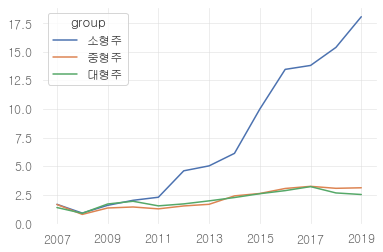

In [19]:
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
df.cumprod(axis=1).transpose().plot.line()